# Visualization of Heart Rate

Just visualize heart rate data collected on an Apple Watch.

Import modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import csv
from tqdm import tqdm_notebook

import sys
sys.path.append('../')
from functions import *

Health data can be exported from the Apple Watch using the Health app on the iPhone.

Read in the resulting data file with the help of some code from https://github.com/minimaxir/get-heart-rate-csv:

In [2]:
# refresh switch
refresh = False

if refresh:
    # note that this file is not pushed to GitHub
    file_name = '/Users/yuempark/GitHub/data-projects/sensitive-data/20190508_export.xml'

    # read in the file, and export to a .csv
    pattern = '^.*IdentifierHeartRate".*startDate="(.{19}).*value="([0-9]*).*$'

    with open('/Users/yuempark/GitHub/data-projects/sensitive-data/20190508-heart-rate.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['dt', 'bpm'])

        with open(file_name, 'r') as f2:
            for line in f2:
                search = re.search(pattern, line)
                if search is not None:
                    writer.writerow([search.group(1), search.group(2)])

    # read in that .csv
    HR = pd.read_csv('/Users/yuempark/GitHub/data-projects/sensitive-data/20190508-heart-rate.csv',
                     parse_dates=['dt'])
    
    # create a day of year and second of day column
    for i in tqdm_notebook(range(len(HR.index))):
        HR.loc[i,'dayofyear'] = HR['dt'][i].dayofyear
        HR.loc[i,'secondofday'] = HR['dt'][i].hour*3600 + HR['dt'][i].minute*60 + HR['dt'][i].second
        
    # sort by time
    HR.sort_values('dt',inplace=True)
    HR.reset_index(drop=True, inplace=True)
        
    HR.to_csv('/Users/yuempark/GitHub/data-projects/sensitive-data/20190508-heart-rate.csv', index=False)
        
else:
    HR = pd.read_csv('/Users/yuempark/GitHub/data-projects/sensitive-data/20190508-heart-rate.csv',
                     parse_dates=['dt'])

HR.columns

Index(['dt', 'bpm', 'dayofyear', 'secondofday'], dtype='object')

The range of the data:

In [3]:
print('first data point = {}'.format(HR['dt'][0]))
print('last  data point = {}'.format(HR['dt'][len(HR.index)-1]))
print('---')
print('there are {:.0f} data points'.format(len(HR)))

first data point = 2017-12-25 22:57:00
last  data point = 2019-05-08 10:52:19
---
there are 139146 data points


Plot everything as a line plot:

/Users/yuempark/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


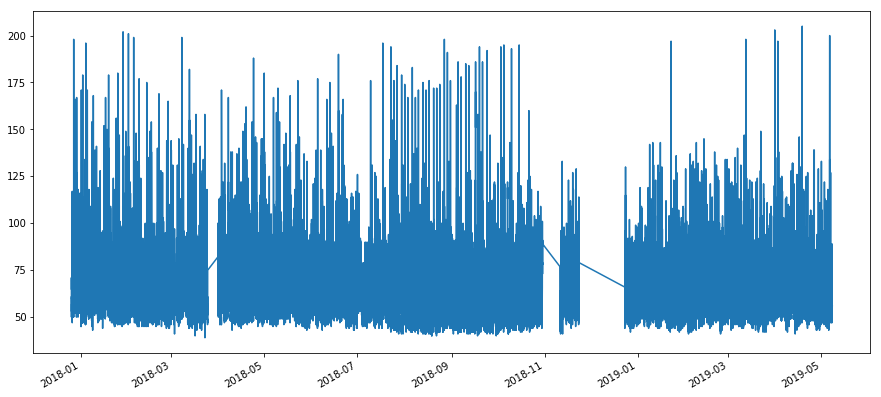

In [4]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(HR['dt'],HR['bpm'])
fig.autofmt_xdate()
plt.show(fig)

Try a nicer visualization, on just the 2018 data. First, slice out the data:

In [5]:
slice_2018 = HR[(HR['dt']>=datetime(2018, 1, 1,hour=0, minute=0, second=0)) &\
                (HR['dt']< datetime(2019, 1, 1,hour=0, minute=0, second=0))].copy()
slice_2018.reset_index(drop=True, inplace=True)
slice_2018.head()

,dt,bpm,dayofyear,secondofday
0,2018-01-01 00:04:21,74,1.0,261.0
1,2018-01-01 00:06:43,74,1.0,403.0
2,2018-01-01 00:06:53,81,1.0,413.0
3,2018-01-01 00:06:57,77,1.0,417.0
4,2018-01-01 00:06:59,77,1.0,419.0


Initialize an array where each column is a day, and each row represents a snapshot of the day:

In [6]:
n_snapshots = 100
HR_array_2018 = np.zeros((n_snapshots,365))

Fill that array by linearly interpolating to get the equally spaced snapshots:

In [7]:
# create the second of day that we will interpolate onto
seconds_in_day = 60*60*24
secondofday_interp = np.linspace(10*60, seconds_in_day-10*60, n_snapshots)

# iterate through each day
for i in range(365):
    
    # get data for this day
    slice_day = slice_2018[slice_2018['dayofyear']==i+1]
    
    if len(slice_day)!=0:
    
        # pull out the second of day and the bpm for this day
        secondofday_i = slice_day['secondofday'].values
        bpm_i = slice_day['bpm'].values

        # linearly interpolate, and set values outside of the x-range to be 0
        bpm_i_interp = np.interp(secondofday_interp, secondofday_i, bpm_i,
                                 left=0, right=0)

        # store it
        HR_array_2018[:,i] = bpm_i_interp
        
# replace zeros with NaNs
HR_array_2018[HR_array_2018==0] = np.nan

Plot:

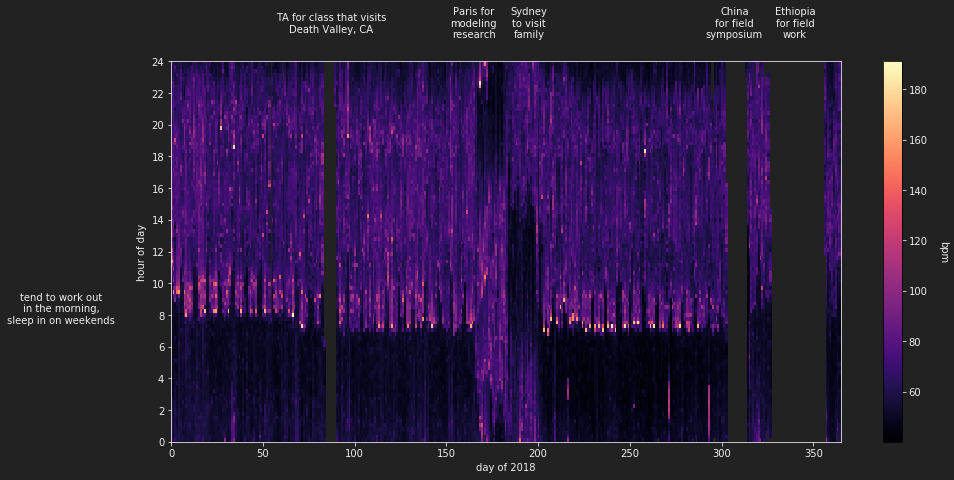

In [8]:
# set up the figure
fig, ax = plt.subplots(figsize=(15,7))

c_bg = '#222222'
c_ax = '#eeeeee'
change_fig_theme(fig, [ax], c_bg, c_ax)

# plot
c = ax.pcolor(HR_array_2018, cmap='magma')

# create the ticks for the y-axis
ax.set_yticks(np.linspace(0,100,13))
ax.set_yticklabels(np.linspace(0,24,13).astype(int))

# prettify
ax.set_xlabel('day of 2018')
ax.set_ylabel('hour of day')

# colorbar
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('bpm', rotation=270, labelpad=20, color=c_ax)
cbar.ax.tick_params(axis='x', colors=c_ax)
cbar.ax.tick_params(axis='y', colors=c_ax)
cbar.ax.yaxis.label.set_color(c_ax)
cbar.ax.xaxis.label.set_color(c_ax)

# annotations
ax.text(87, 110, 'TA for class that visits\nDeath Valley, CA',
        horizontalalignment='center', verticalalignment='center', color=c_ax)

ax.text(165, 110, 'Paris for\nmodeling\nresearch',
        horizontalalignment='center', verticalalignment='center', color=c_ax)

ax.text(195, 110, 'Sydney\nto visit\nfamily',
        horizontalalignment='center', verticalalignment='center', color=c_ax)

ax.text(307, 110, 'China\nfor field\nsymposium',
        horizontalalignment='center', verticalalignment='center', color=c_ax)

ax.text(340, 110, 'Ethiopia\nfor field\nwork',
        horizontalalignment='center', verticalalignment='center', color=c_ax)

ax.text(-60, 35, 'tend to work out\nin the morning,\nsleep in on weekends',
        horizontalalignment='center', verticalalignment='center', color=c_ax)

#plt.savefig('2018-heart-rate-interpolated.jpg', bbox_inches='tight', facecolor=c_bg, dpi=300)
plt.show(fig)

How are things different in 2019?

In [9]:
slice_2019 = HR[(HR['dt']>=datetime(2019, 1, 1,hour=0, minute=0, second=0)) &\
                (HR['dt']< datetime(2020, 1, 1,hour=0, minute=0, second=0))].copy()
slice_2019.reset_index(drop=True, inplace=True)
slice_2019.head()

,dt,bpm,dayofyear,secondofday
0,2019-01-01 00:04:41,71,1.0,281.0
1,2019-01-01 00:09:04,73,1.0,544.0
2,2019-01-01 00:17:13,74,1.0,1033.0
3,2019-01-01 00:20:30,80,1.0,1230.0
4,2019-01-01 00:25:00,71,1.0,1500.0


In [10]:
days_2019_so_far = np.int(np.max(slice_2019['dayofyear']))

HR_array_2019 = np.zeros((n_snapshots, days_2019_so_far))

# iterate through each day
for i in range(days_2019_so_far):
    
    # get data for this day
    slice_day = slice_2019[slice_2019['dayofyear']==i+1]
    
    if len(slice_day)!=0:
    
        # pull out the second of day and the bpm for this day
        secondofday_i = slice_day['secondofday'].values
        bpm_i = slice_day['bpm'].values

        # linearly interpolate, and set values outside of the x-range to be 0
        bpm_i_interp = np.interp(secondofday_interp, secondofday_i, bpm_i,
                                 left=0, right=0)

        # store it
        HR_array_2019[:,i] = bpm_i_interp
        
# replace zeros with NaNs
HR_array_2019[HR_array_2019==0] = np.nan

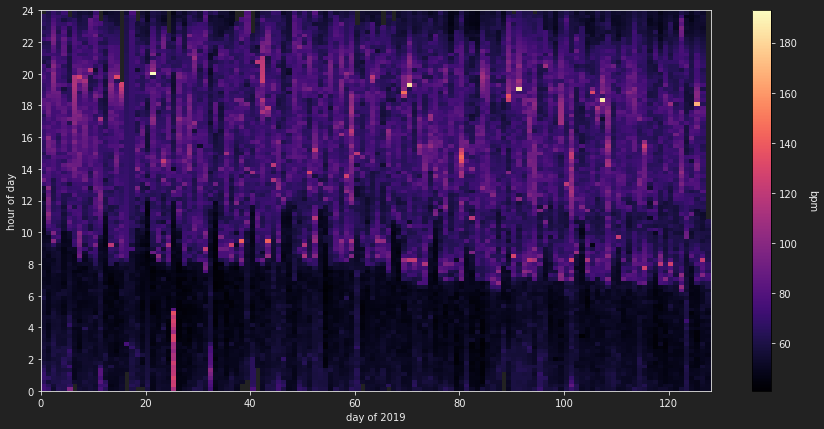

In [11]:
# set up the figure
fig, ax = plt.subplots(figsize=(15,7))

c_bg = '#222222'
c_ax = '#eeeeee'
change_fig_theme(fig, [ax], c_bg, c_ax)

# plot
c = ax.pcolor(HR_array_2019, cmap='magma')

# create the ticks for the y-axis
ax.set_yticks(np.linspace(0,100,13))
ax.set_yticklabels(np.linspace(0,24,13).astype(int))

# prettify
ax.set_xlabel('day of 2019')
ax.set_ylabel('hour of day')

# colorbar
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('bpm', rotation=270, labelpad=20, color=c_ax)
cbar.ax.tick_params(axis='x', colors=c_ax)
cbar.ax.tick_params(axis='y', colors=c_ax)
cbar.ax.yaxis.label.set_color(c_ax)
cbar.ax.xaxis.label.set_color(c_ax)

plt.show(fig)

**NOTE:** this data is not representative though - almost all work outs in 2019 so far have been kickboxing, during which I take off my watch. We're going to have to come up with some way to impute the missing data...